In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 200)

In [2]:
df = pd.read_excel(r"C:\Users\dogan\OneDrive\Desktop\amazon.xlsx")


In [3]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [5]:
# Normalizing Case Folding

df["Review"] = df["Review"].str.lower()

#Punctuations

df["Review"] = df["Review"].str.replace("[^\w\s]", "")

#Numbers

df["Review"] = df["Review"].str.replace("\d", "")

#Stopwords

sw = stopwords.words("english")
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

# Rarewords / Custom Words

sil = pd.Series(" ".join(df["Review"]).split()).value_counts()[-1000:]
df["Review"] = df["Review"].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

#Lemmatization

df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df["Review"].head(10)

0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck cant believe quality material ...
5                                 look different photo
6    exactly looking heavy material great price shi...
7    looking picture thought curtain would thinner ...
8    much whiter thought would wasnt really expecti...
9    curtain picture show rd set ambesonne curtain ...
Name: Review, dtype: object

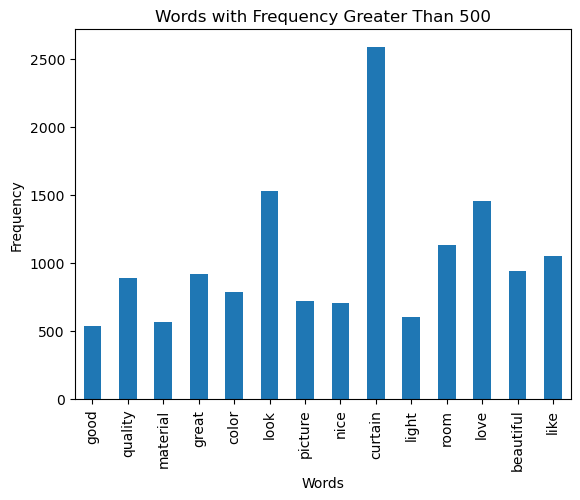

In [6]:
# Assuming 'df' is your DataFrame and 'Review' is the column containing the text data
tf = df['Review'].apply(lambda x: pd.value_counts(x.split())).sum(axis=0).reset_index()
tf.columns = ['words', 'tf']
tf = tf[tf['tf'] > 500]  # Filter words with frequency greater than 500

# Plot the barplot
tf.plot.bar(x='words', y='tf', legend=False)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Words with Frequency Greater Than 500')
plt.show()


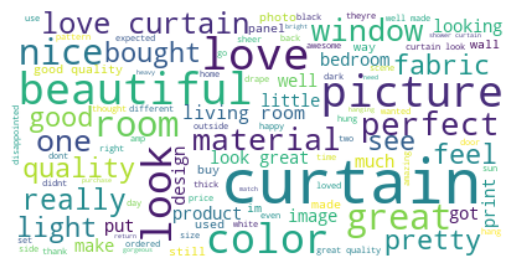

In [7]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                     max_words=100,
                     background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
# Step 1: Install NLTK if you haven't already
# You can install it using pip
!pip install nltk

# Step 2: Download the VADER lexicon
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dogan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
### Emotional Analysis

sia = SentimentIntensityAnalyzer()
#investigating polarity score with sia

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [10]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [11]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]>0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [12]:
df["Sentiment_label"]= df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]>0 else "neg")

In [13]:
df.groupby("Sentiment_label")["Star"].mean()

Sentiment_label
neg   3.39
pos   4.59
Name: Star, dtype: float64

In [14]:
## Preperation to ML

#Determining dependent and independent variable and splitting data to train and test

train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                   df["Sentiment_label"],
                                                   random_state=42)

In [15]:
# TF-IDF Word Level

tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [17]:
#Modelling(logistic Regression)

log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [18]:
cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

0.8546034570411795

In [37]:
random_review = pd.Series(df["Review"].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(new_comment)
print(f'Review: {random_review[0]} \n Prediction: {pred}')

Review: love curtain exactly pictured quality detail impressive lead believe picture first felt like price high got realized paying great quality craftsmanship feel much comfortable pricebrim happy took chance thesebrbri note minor discrepancy length one side seems fluctuate give take inch way across mild gradual curve noticeable looking id curious know change washed chose wash mine ever update resultsbrand didnt wash wrinkle box 
 Prediction: ['pos']


In [38]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8902389425521099